In [1]:
%load_ext autoreload
%autoreload 2 

In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid

In [7]:
model_path = Path('results/aug_11_loss1/')

In [8]:
# submission_path = model_path/'predictions.npy'
submission_path = model_path/'predictions_tta.npy'
predictions = sigmoid(np.load(submission_path))
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
public748 = pd.read_csv('input/public748.csv')

In [9]:
# test['target'] = predictions.reshape(-1) * 0.2 + public748['target'].values * 0.8
test['target'] = predictions.reshape(-1)
# test['target'] = predictions[0]

In [10]:
test

,id,target
0,00054c878,0.374404
1,0007285a3,0.615137
2,00076c5a6,0.211941
3,001349290,0.210326
4,001a52e92,0.252351
...,...,...
7970,ffbce04ef,0.946809
7971,ffc2d976b,0.189028
7972,ffc905909,0.172807
7973,ffe276f3e,0.283340


In [11]:
test.to_csv(model_path/'submission.csv', index=False)
# test.to_csv(model_path/'blend_submission.csv', index=False)

# Split

In [35]:

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v1.csv')
# splitter = MultilabelStratifiedKFold(n_splits=5, shuffle=True)
# y = pd.get_dummies(pd.cut(df['signal_depth'], [0, 20, 40, 60, 80, 100, 1000]))
# for train_idx, valid_idx in list(splitter.split(df, y)):
#     train_fold = df.iloc[train_idx]
#     valid_fold = df.iloc[valid_idx]
#     print(train_fold['target'].mean(), valid_fold['target'].mean())
#     display(y.iloc[train_idx].mean(0))
#     display(y.iloc[valid_idx].mean(0))

# Error analysis

In [23]:
oof_path = model_path/'outoffolds.npy'
oof = sigmoid(np.load(oof_path))

In [24]:
train = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
train = train.loc[train['target'] != -1]
train['pred'] = oof

In [25]:
train['error'] = (train['target'] - train['pred']).abs()
train

,id,target,pred,error
0,001121a05,1,0.439746,0.560254
1,004f23b2d,1,0.999914,0.000086
2,00a6db666,1,0.999939,0.000061
3,00f36a6ac,1,0.963997,0.036003
4,010a387db,1,0.406304,0.593696
...,...,...,...,...
598,fe38dbe64,1,0.689792,0.310208
599,feafd0d16,1,0.999974,0.000026
600,feeca844e,1,0.999901,0.000099
601,ff5ad023f,1,0.462279,0.537721


In [26]:
from datasets import G2Net2022Dataset
import matplotlib.pyplot as plt
from transforms import *

In [31]:
ds = G2Net2022Dataset(
    df=train.sort_values('error', ascending=False).head(50),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/train'), 
    spec_diff=True,
    resize_factor=4, 
    # transforms=None,
    normalize='local',
    transforms=RandomCrop(1024)
)

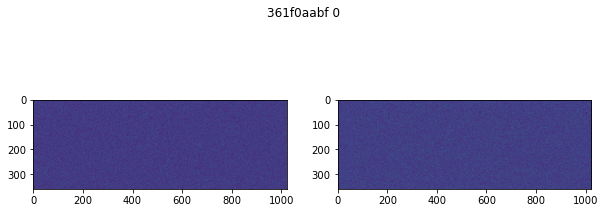

In [32]:
export_dir = Path('input/plot')
for i in range(50):
    r = train.sort_values('error', ascending=False).head(50).iloc[i]
    fname = r.id
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{fname} {r.target}')
    specs = ds[i][0]
    plt.subplot(1, 2, 1)
    plt.imshow(specs[:, :, 0])
    plt.subplot(1, 2, 2)
    plt.imshow(specs[:, :, 1])
    # plt.savefig(export_dir/f'{fname}.png', facecolor='white')
    # plt.close()

    plt.show()
    break